In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")
from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate, pipelines

 
from tqdm import tqdm  # progress bar

In [15]:
trebl_exp_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

trebl_exp_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)
trebl_exp_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

# 1. Puro only, no err corr

In [87]:
pipeline_no_err_corr_puro_only = pipelines.TreblPipeline(db_path = "",
                        design_file_path = "",
                        error_correction = False,
                        output_path = "../../output/NKX2-2/TL4B2/puro_only/no_err_corr")


In [93]:
activity_mean, activity_summed = pipeline_no_err_corr_puro_only.calculate_activity_scores(step1_path = "../../output/NKX2-2/pipeline_test/no_err_corr/step1.csv",
        AD_bc_objects = [trebl_exp_ADBC2, trebl_exp_HawkBCs],
        RT_bc_objects = [trebl_exp_RTBC],
        time_regex = r'_T(\d+)_',
        rep_regex = r'_R(\d+)_'
    )

In [94]:
activity_mean

time                                                          0         4   \
AD                                                 rep                       
ACCGACGCCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGAT... 1         NaN       NaN   
                                                   2         inf  0.215686   
                                                   3         NaN  0.807692   
                                                   4         NaN  1.363636   
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    6.513889  0.209914   
...                                                          ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4         inf       inf   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1         inf       inf   
                                                   2         inf       inf   
                                                   3         inf       inf   
                                                   4         inf       inf   

time                                                          24        48  
AD                                                 rep                      
ACCGACGCCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGAT... 1         inf       NaN  
                                                   2    0.460526  0.322388  
                                                   3    0.900000  0.000000  
                                                   4    0.216981  0.800000  
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    0.799833       inf  
...                                                          ...       ...  
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4         inf       inf  
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    1.230835       inf  
                                                   2         inf       inf  
                                                   3         inf       inf  
                                                   4    5.255118  3.718871  

[897 rows x 4 columns]

In [95]:
activity_summed

time                                                          0         4   \
AD                                                 rep                       
ACCGACGCCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGAT... 1         NaN       NaN   
                                                   2         inf  0.215686   
                                                   3         NaN  0.807692   
                                                   4         NaN  1.363636   
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    0.205479  0.363344   
...                                                          ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    1.468085  0.536709   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    9.200000  0.428382   
                                                   2    0.250229  0.428733   
                                                   3    4.128205  0.961859   
                                                   4    1.477612  0.610398   

time                                                          24           48  
AD                                                 rep                         
ACCGACGCCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGAT... 1         inf          NaN  
                                                   2    0.460526     0.322388  
                                                   3    0.900000     0.000000  
                                                   4    0.216981     0.800000  
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    1.407127          inf  
...                                                          ...          ...  
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    0.876188     0.569870  
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    1.158668  1493.500000  
                                                   2    1.602429     1.055864  
                                                   3    1.148434     0.573390  
                                                   4    1.335161     0.737480  

[897 rows x 4 columns]

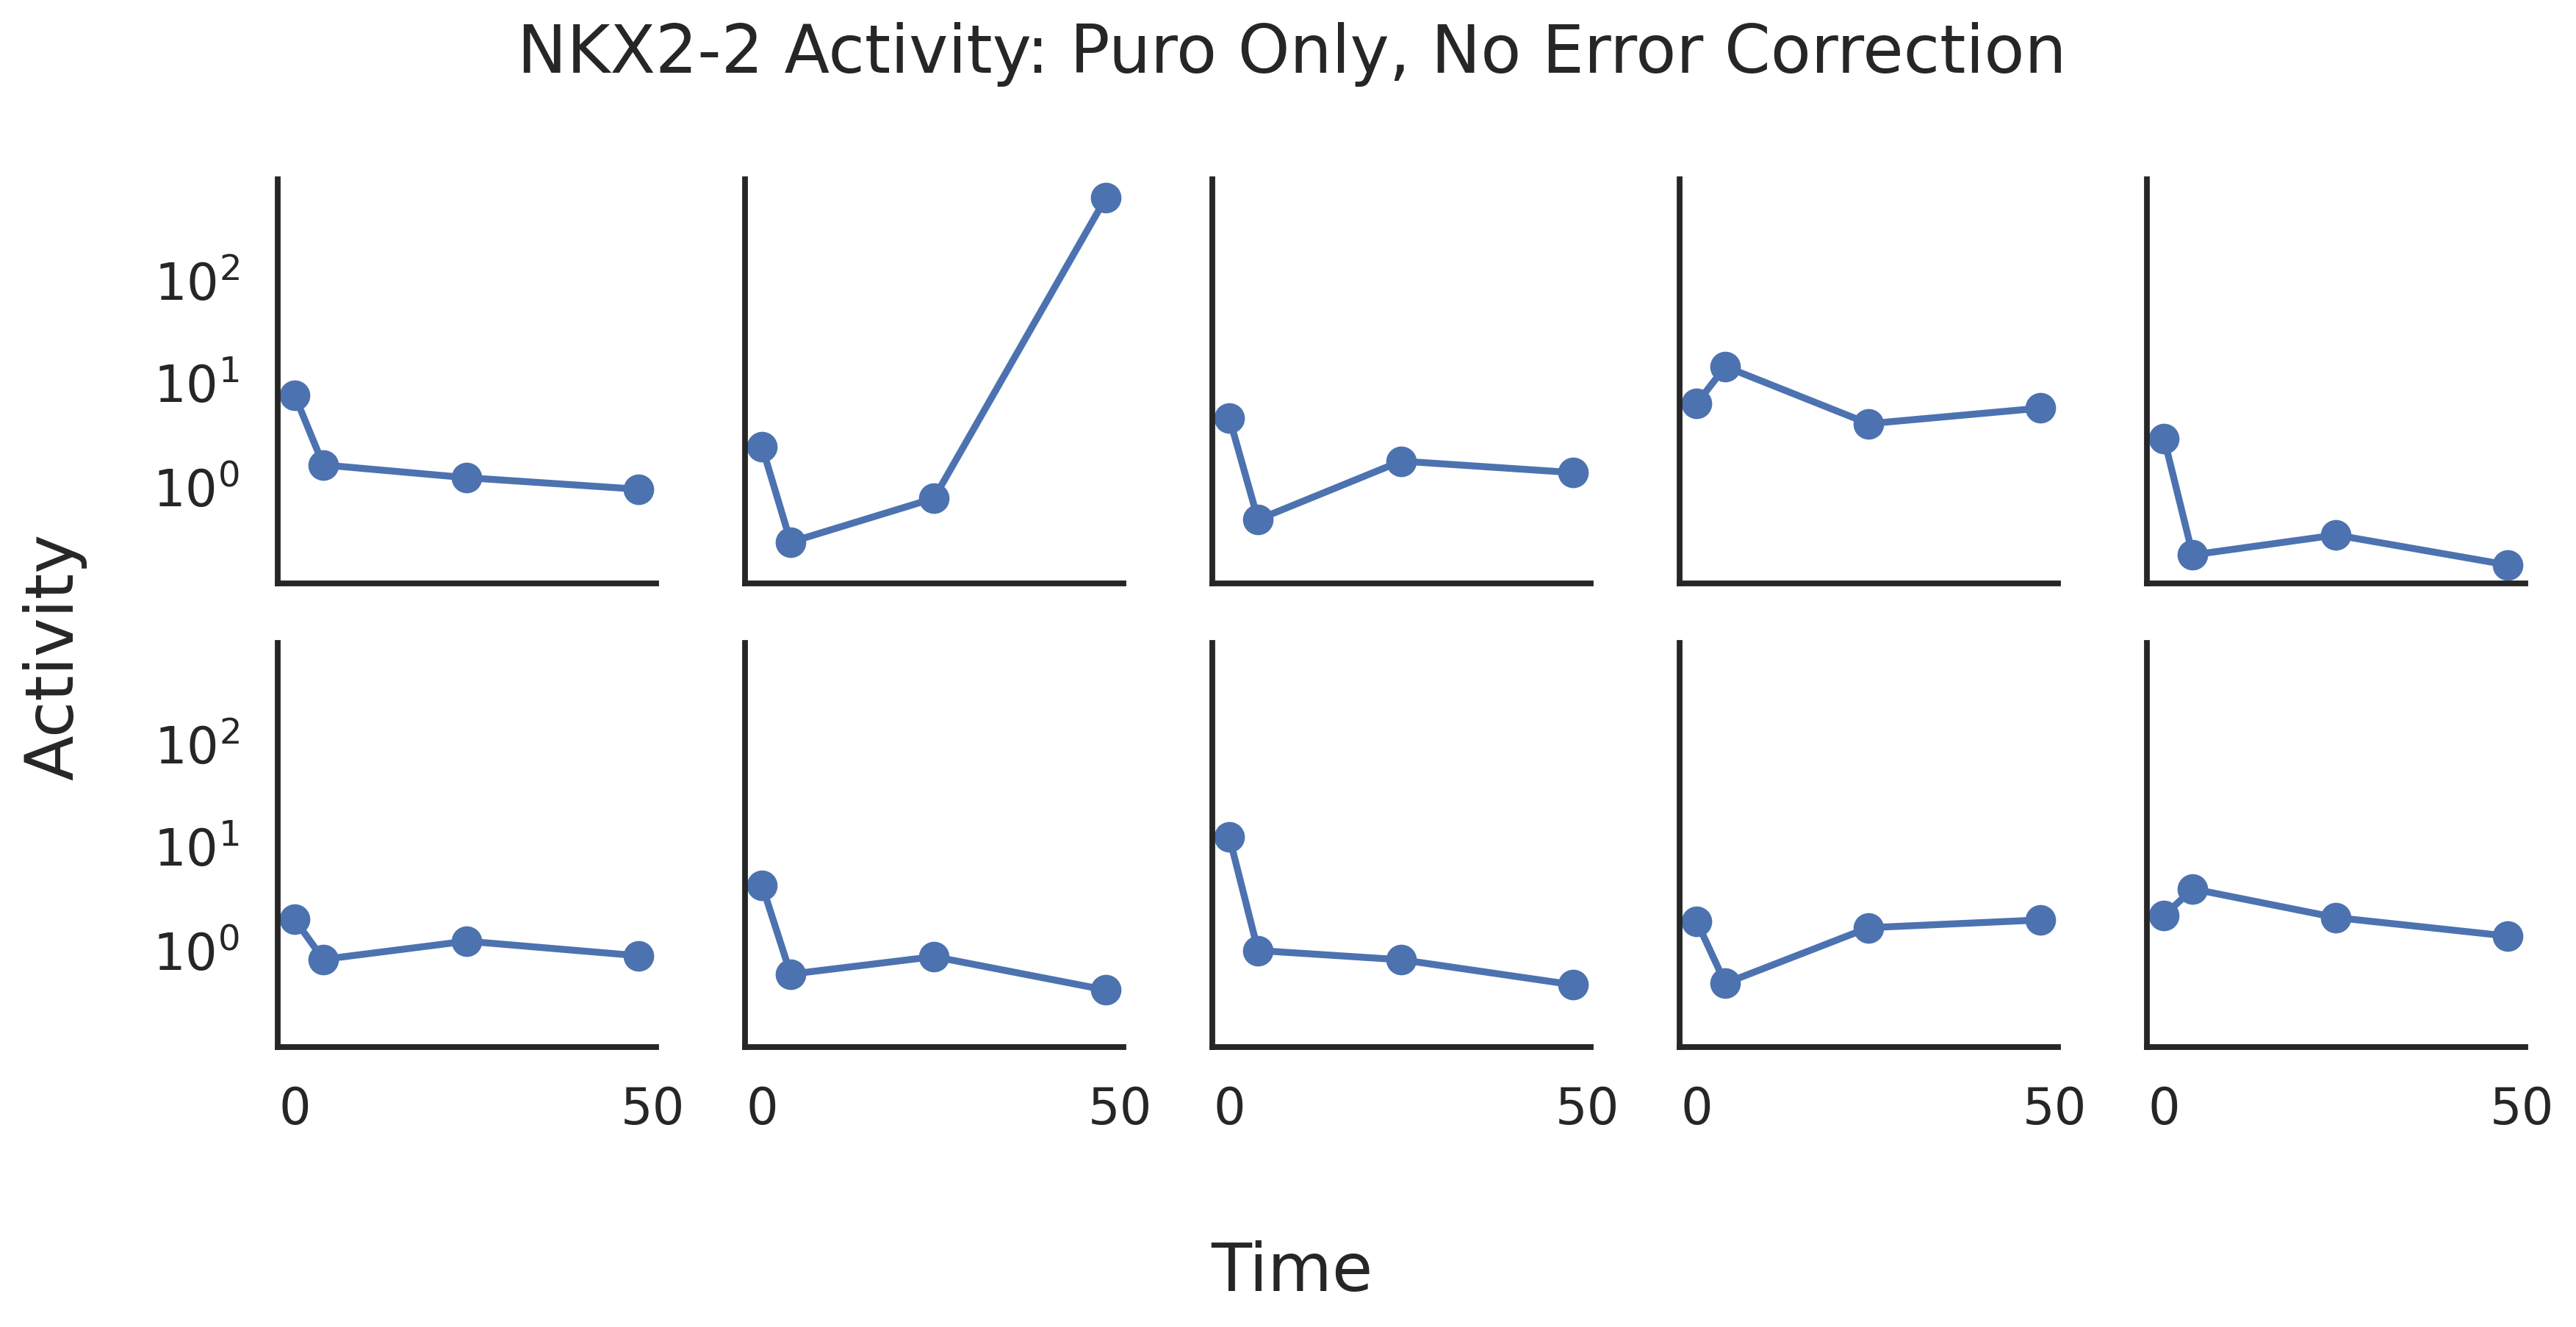

In [99]:
time_columns = [col for col in activity_mean.columns if isinstance(col, int)]

activity_mean['na_count'] = activity_mean.isna().sum(axis=1)

# Filter rows with no nulls (na_count == 0) and no infinite values
no_nulls_no_inf = activity_mean[(activity_mean['na_count'] == 0) & 
                                           (~activity_mean[time_columns].isin([float('inf')]).any(axis=1))]

# Filter rows with no nulls (na_count == 0) and select the first 10 rows
no_nulls_no_inf_subset = no_nulls_no_inf.sample(10)

# Select columns corresponding to time points (0-60)
time_columns = [col for col in activity_mean.columns if isinstance(col, int)]

# Plot lineplot with 10 subplots
fig, axes = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey = True, dpi = 300)
axes = axes.flatten()

for i, (index, row) in enumerate(no_nulls_no_inf_subset.iterrows()):
    ax = axes[i]
    ax.plot(time_columns, row[time_columns], marker='o')
    ax.set_yscale('log')

fig.supylabel("Activity")
fig.supxlabel("Time")

plt.suptitle("NKX2-2 Activity: Puro Only, No Error Correction")
sns.despine()
plt.tight_layout()
plt.show()

# 2. Rim, no err corr

In [100]:
pipeline_no_err_corr_rim = pipelines.TreblPipeline(db_path = "",
                        design_file_path = "",
                        error_correction = False,
                        output_path = "../../output/NKX2-2/TL4B2/rim/no_err_corr")


In [101]:
activity_mean_rim, activity_summed_rim = pipeline_no_err_corr_rim.calculate_activity_scores(step1_path = "../../output/NKX2-2/pipeline_test/no_err_corr/step1.csv",
        AD_bc_objects = [trebl_exp_ADBC2, trebl_exp_HawkBCs],
        RT_bc_objects = [trebl_exp_RTBC],
        time_regex = r'T(\d+)',
        rep_regex = r'R(\d+)'
    )

In [102]:
activity_mean_rim

time                                                          0         4   \
AD                                                 rep                       
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    3.035729  1.274739   
                                                   2    4.227889  0.952963   
                                                   3    5.617969  0.967457   
                                                   4         inf       inf   
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1         inf  0.535860   
...                                                          ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    6.529641  0.645853   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    5.412007  0.964500   
                                                   2         inf  0.748452   
                                                   3    9.054849  0.959533   
                                                   4         inf       inf   

time                                                           6         24  \
AD                                                 rep                        
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1     3.089943  1.825953   
                                                   2     1.246190  1.239305   
                                                   3     2.330575  1.934048   
                                                   4    13.501381       inf   
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1     1.240475  0.745638   
...                                                           ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4          inf  0.802612   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1     2.164033       inf   
                                                   2     0.789712  1.043322   
                                                   3     2.693837  2.149543   
                                                   4          inf       inf   

time                                                          48  
AD                                                 rep            
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    1.254359  
                                                   2    7.421662  
                                                   3    1.653242  
                                                   4         inf  
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1    0.392915  
...                                                          ...  
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    0.000966  
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    1.110729  
                                                   2    2.742500  
                                                   3         inf  
                                                   4         inf  

[832 rows x 5 columns]

In [103]:
activity_summed_rim

time                                                          0         4   \
AD                                                 rep                       
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    0.726334  1.274739   
                                                   2    0.953953  0.907132   
                                                   3    0.618430  0.928979   
                                                   4    0.699773  1.219512   
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1    0.325370  0.504835   
...                                                          ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    0.560137  0.636598   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    0.600492  0.829122   
                                                   2    0.900337  0.704444   
                                                   3    1.139440  1.081372   
                                                   4    2.931957  4.039370   

time                                                          6         24  \
AD                                                 rep                       
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    3.089943  1.825953   
                                                   2    1.121076  1.690653   
                                                   3    2.275883  1.966258   
                                                   4    1.634615  1.466395   
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1    1.144239  0.653193   
...                                                          ...       ...   
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    1.032817  0.938970   
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    1.975227  1.415260   
                                                   2    0.844027  0.892234   
                                                   3    2.876429  2.285318   
                                                   4    8.137838  6.988290   

time                                                          48  
AD                                                 rep            
ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGAT... 1    1.254359  
                                                   2    5.365854  
                                                   3    1.854480  
                                                   4    0.019608  
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGAT... 1    0.383976  
...                                                          ...  
TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAG... 4    0.000864  
TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCAG... 1    0.926357  
                                                   2    2.451336  
                                                   3    1.467576  
                                                   4    0.010782  

[832 rows x 5 columns]

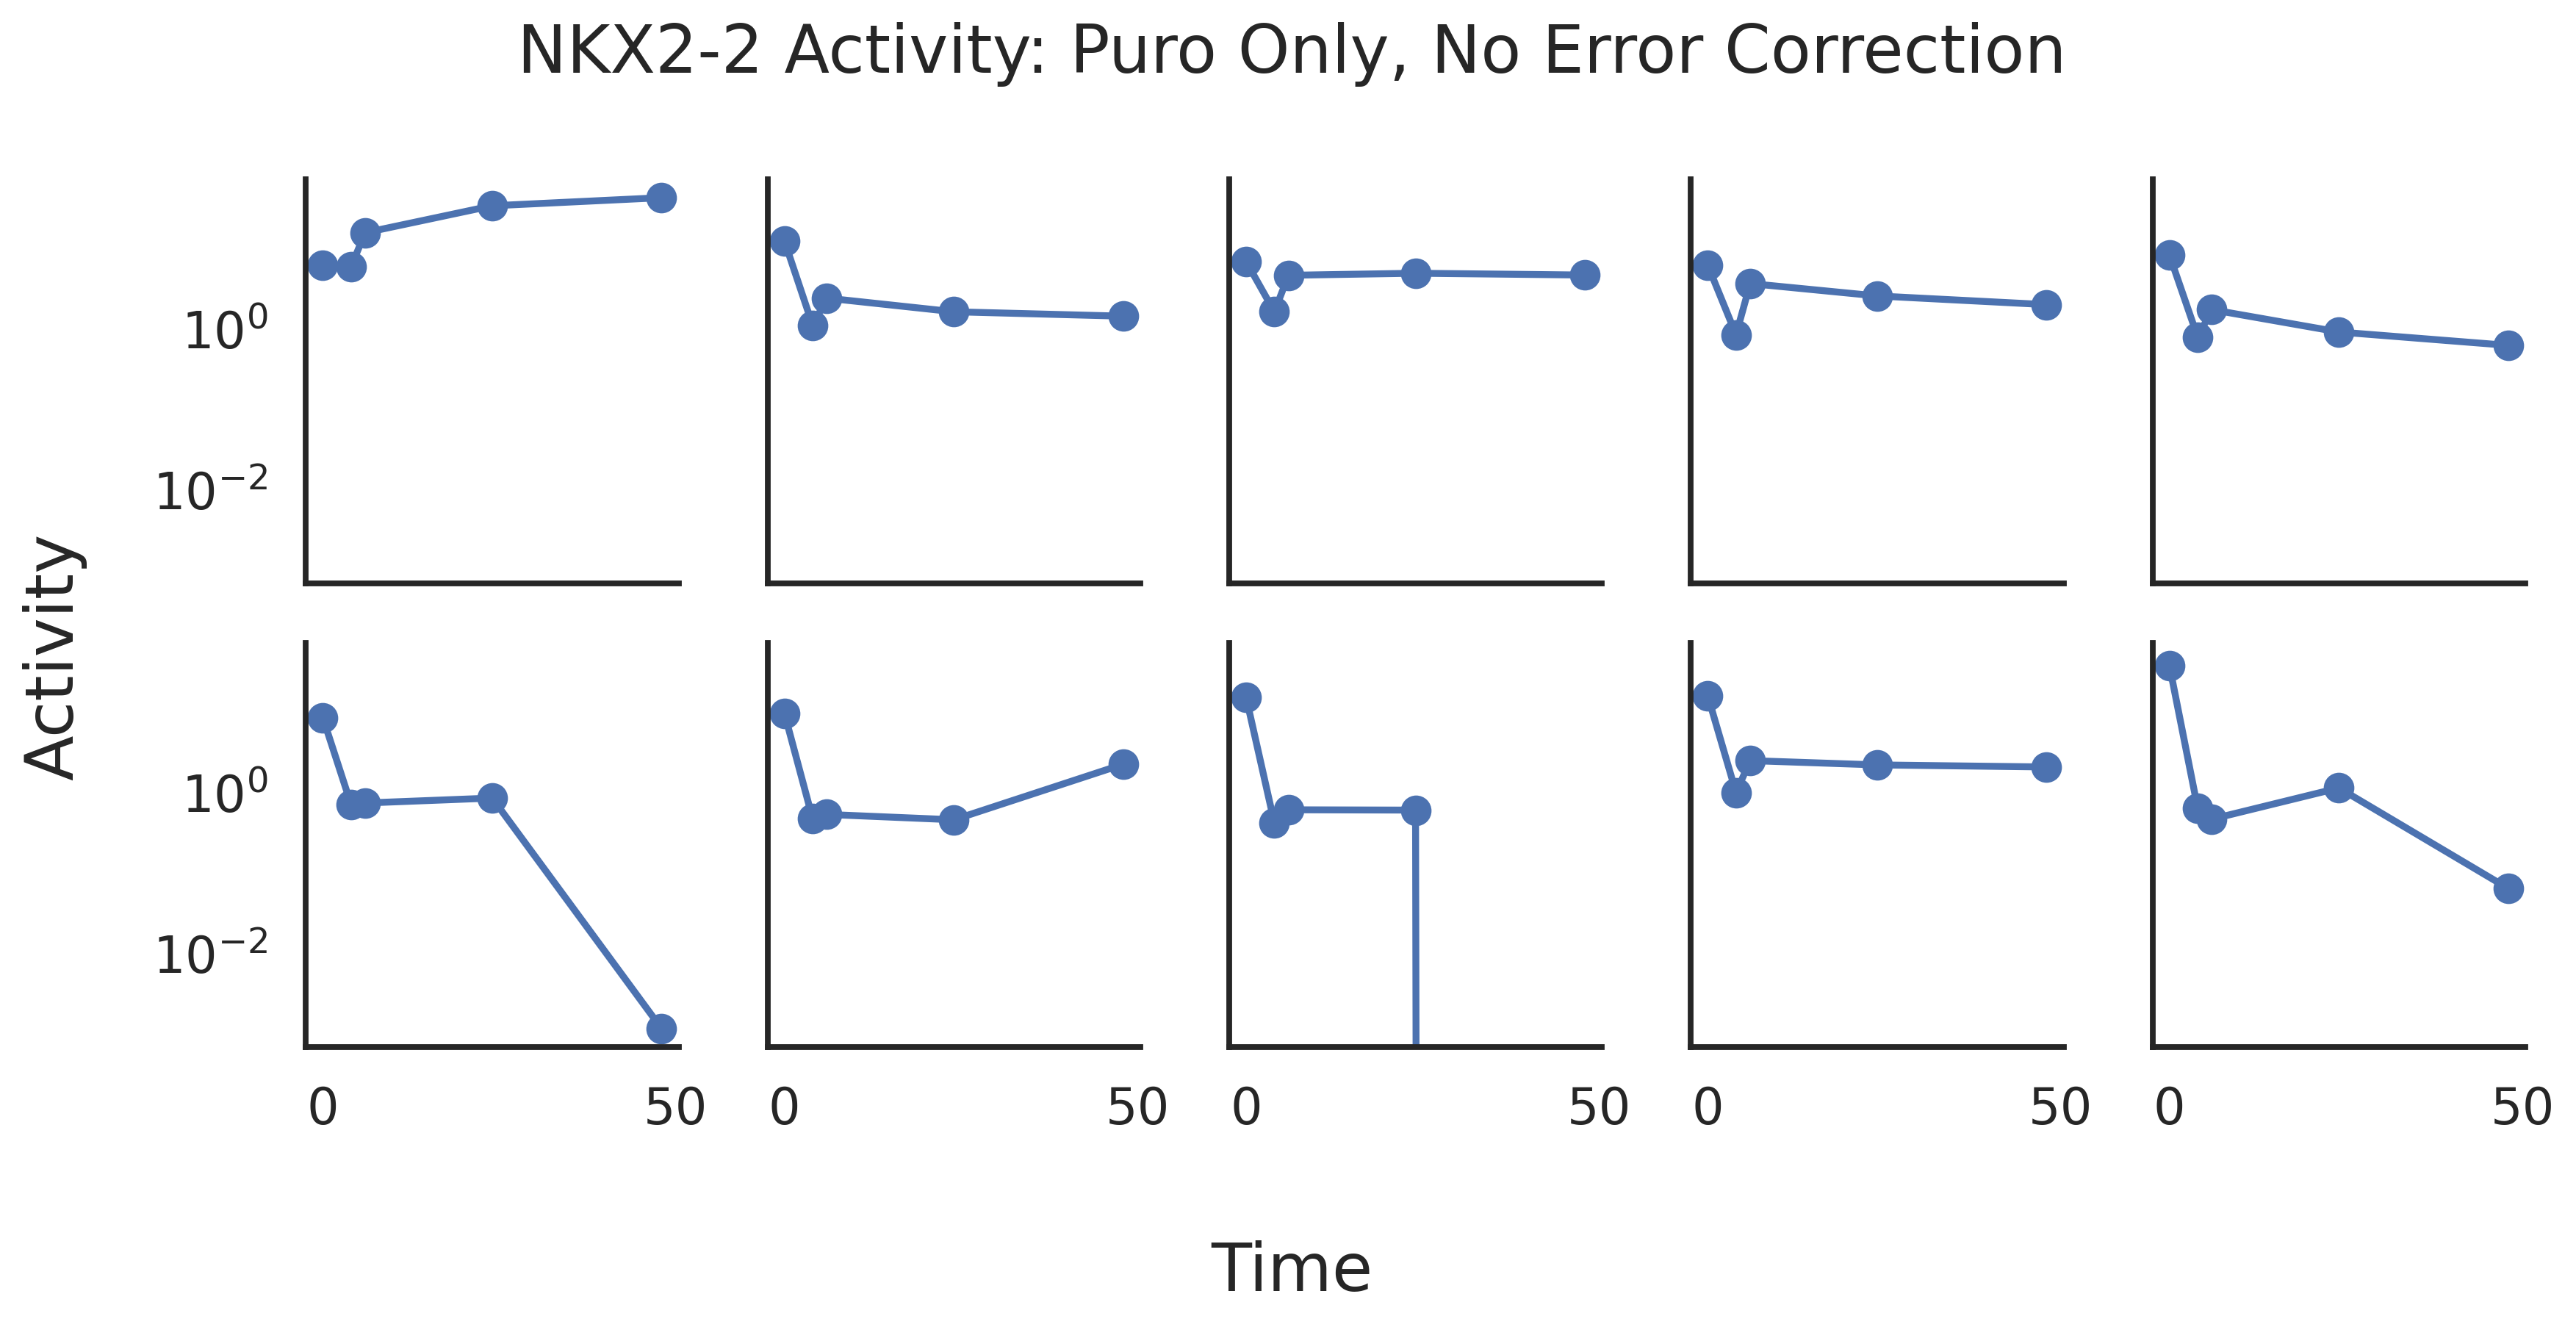

In [106]:
time_columns = [col for col in activity_mean_rim.columns if isinstance(col, int)]

activity_mean_rim['na_count'] = activity_mean_rim.isna().sum(axis=1)

# Filter rows with no nulls (na_count == 0) and no infinite values
no_nulls_no_inf = activity_mean_rim[(activity_mean_rim['na_count'] == 0) & 
                                           (~activity_mean_rim[time_columns].isin([float('inf')]).any(axis=1))]

# Filter rows with no nulls (na_count == 0) and select the first 10 rows
no_nulls_no_inf_subset = no_nulls_no_inf.sample(10)

# Select columns corresponding to time points (0-60)
time_columns = [col for col in activity_mean_rim.columns if isinstance(col, int)]

# Plot lineplot with 10 subplots
fig, axes = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey = True, dpi = 300)
axes = axes.flatten()

for i, (index, row) in enumerate(no_nulls_no_inf_subset.iterrows()):
    ax = axes[i]
    ax.plot(time_columns, row[time_columns], marker='o')
    ax.set_yscale('log')

fig.supylabel("Activity")
fig.supxlabel("Time")

plt.suptitle("NKX2-2 Activity: Puro Only, No Error Correction")
sns.despine()
plt.tight_layout()
plt.show()

# 3. Puro only, err corr

In [107]:
pipeline_err_corr_puro_only = pipelines.TreblPipeline(db_path = "",
                        design_file_path = "",
                        error_correction = False,
                        output_path = "../../output/NKX2-2/TL4B2/puro_only/err_corr_100")


In [108]:
activity_mean_err_corr_puro_only, activity_summed_err_corr_puro_only = pipeline_err_corr_puro_only.calculate_activity_scores(step1_path = "../../output/NKX2-2/pipeline_test/err_corr/step1.csv",
        AD_bc_objects = [trebl_exp_ADBC2, trebl_exp_HawkBCs],
        RT_bc_objects = [trebl_exp_RTBC],
        time_regex = r'_T(\d+)_',
        rep_regex = r'_R(\d+)_'
    )

# 4. Rim, err corr

In [109]:
pipeline_err_corr_rim = pipelines.TreblPipeline(db_path = "",
                        design_file_path = "",
                        error_correction = False,
                        output_path = "../../output/NKX2-2/TL4B2/rim/err_corr_100")


In [110]:
activity_mean_err_corr_rim, activity_summed_err_corr_rim = pipeline_err_corr_rim.calculate_activity_scores(step1_path = "../../output/NKX2-2/pipeline_test/err_corr/step1.csv",
        AD_bc_objects = [trebl_exp_ADBC2, trebl_exp_HawkBCs],
        RT_bc_objects = [trebl_exp_RTBC],
        time_regex = r'T(\d+)',
        rep_regex = r'R(\d+)'
    )